## Lab 1 deteccion de Pishing

#### Brandon Ronaldo Sicay Cumes - 21757

In [25]:
from sklearn.preprocessing import LabelEncoder
import datetime
import pandas as pd
from urllib.parse import urlparse
import whois
import re
import ssl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from urllib.parse import urlparse, parse_qs
import math
from ydata_profiling import ProfileReport



### **Parte 1 – Ingeniería de características**

#### Exploración de datos

1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones

In [12]:
data = pd.read_csv('dataset_pishing.csv')
data.head(5)


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [13]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?

In [14]:
data['status'].value_counts()


status
legitimate    5715
phishing      5715
Name: count, dtype: int64

El dataset sí stá balanceado.



#### Derivación de características

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?

- Extracción: Los features de una URL son fáciles de extraer y analizar, en comparación con otras métricas, comom lo es el tiempo de vida del dominio.
- Accesibilidad: Las URLs son públicas y accesibles, lo que nos permite un análisis sin requerir acceso a información privada.
- Rapidez: La URL proporciona información directa sobre una dirección web, facilitando la evaluación inmediata de su validez.

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?
- Shorted URL: Los atacantes usan URLs acortadas para ocultar el destino real del enlace, logrando que los usuarios tengan más dificultal al identificar sitios maliciosos.
- HTTPS: Los sitios de phishing a menudo no utilizan HTTPS, o no tienen los certificados implementados de manera correcta.
- Direcciones IP puesta en el nombre del dominio: Los atacantes a menudo usan direcciones IP (http://192.168.1.1/...) en lugar de nombres de dominio, ya que dificulta la asociación con una entidad legítima.
- Uso de caracteres especiales y patrones aleatorios:La presencia de caracteres inusuales, guiones, números o combinaciones de letras que aumentan la entropía del nombre de dominio o de la ruta puede indicar que la URL fue generada automáticamente. 
- Coincidencia de marca: La similitud del dominio con nombres de marcas reconocidas (por ejemplo, “micr0soft” en lugar de “microsoft”) o el uso de caracteres visualmente similares. Los atacantes a menudo manipulan letras para que la URL parezca legítima.





En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original.
Incluya dentro de las quince funciones, la entropía de Shanon y relativa.

In [15]:
def has_random_numeric_strings(url):
    pattern = re.compile(r'\d{5,}')  # sequences of 5 or more digits
    matches = re.findall(pattern, url)
    return len(matches)

def uses_https(url):
    parsed_url = urlparse(url)
    return 1 if parsed_url.scheme == 'https' else 0

def number_letter_ratio_in_path(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    letters = sum(c.isalpha() for c in path)
    numbers = sum(c.isdigit() for c in path)
    if numbers == 0: 
        return 0
    return letters / numbers

def letter_ratio_in_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    letters = sum(c.isalpha() for c in domain)
    if len(domain) == 0: 
        return 0
    return letters / len(domain)


def sensitive_keywords(url):
    sensitive_words = ["login", "password", "bank", "paypal", "account", "secure", "verify"]
    count = sum(url.lower().count(word) for word in sensitive_words)
    return count

def domain_age(url): 
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        domain_info = whois.whois(domain)

        creation_date = domain_info.creation_date

        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        age = (datetime.now() - creation_date).days

        return int(age)

    except Exception as e:
        return 0

def count_hyphens_and_underscores(url):
    hyphen_count = url.count("-")
    underscore_count = url.count("_")
    return hyphen_count + underscore_count

def check_suspicious_tld(url):
    suspicious_tlds = [".tk", ".ml", ".ga", ".cf", ".gq"]  # suspicious TLDs
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split(".")[-1]

    if "." + tld in suspicious_tlds:
        return 1  
    else:
        return 0  

def url_length(url):
    return len(url)

def subdomain_count(url):
    parsed_url = urlparse(url)
    return len(parsed_url.netloc.split('.')) - 2 

def vowel_consonant_ratio (x):
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: 
        ratio = 0
    return ratio

def count_redirects(url):
    response = requests.get(url, allow_redirects=False)
    return len(response.history)

def extract_path_extensions(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    return len([part.split('.')[-1] for part in path.split('/') if '.' in part])

def count_special_characters(url):
    special_character_pattern = re.compile(r'[^a-zA-Z0-9]')
    special_characters = re.findall(special_character_pattern, url)
    return len(special_characters)

def domain_length(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return len(domain)

In [18]:
data['length'] = data['url'].apply(url_length)
data['vowels'] = data['url'].apply(vowel_consonant_ratio)
data['subdomain'] = data['url'].apply(subdomain_count)
data['paths'] = data['url'].apply(extract_path_extensions)
data['https'] = data['url'].apply(uses_https)
data['num_letter_ratio_path'] = data['url'].apply(number_letter_ratio_in_path)
data['num_letter_ratio_domain'] = data['url'].apply(letter_ratio_in_domain)
data['special_char'] = data['url'].apply(count_special_characters)
data['domain_length'] = data['url'].apply(domain_length)
data['sensitive_keywords'] = data['url'].apply(sensitive_keywords)
data['suspicious_tld'] = data['url'].apply(domain_age)
data['rand_numstring'] = data['url'].apply(has_random_numeric_strings)
data['hyphens'] = data['url'].apply(count_hyphens_and_underscores)
data['domain_age'] = data['url'].apply(domain_age)

data['status'] = data['status'].replace(to_replace = 'legitimate', value=1)
data['status'] = data['status'].replace(to_replace = 'phishing', value=0)

print(data.head())

                                                 url  status  length  \
0              http://www.crestonwood.com/router.php       1      37   
1  http://shadetreetechnology.com/V4/validation/a...       0      77   
2  https://support-appleld.com.secureupdate.duila...       0     126   
3                                 http://rgipt.ac.in       1      18   
4  http://www.iracing.com/tracks/gateway-motorspo...       1      55   

     vowels  subdomain  paths  https  num_letter_ratio_path  \
0  0.363636          1      1      0               0.000000   
1  0.827586          0      0      0               1.588235   
2  0.517241          3      0      1               0.888889   
3  0.300000          1      0      0               0.000000   
4  0.363636          1      0      0               0.000000   

   num_letter_ratio_domain  special_char  domain_length  sensitive_keywords  \
0                 0.894737             7             19                   0   
1                 0.956522    

#### Preprocesamiento

In [20]:
data_final = data
data_final = data_final.drop(['url'], axis=1)
data_final.to_csv('phishing_features.csv', index=False)
data_final.head()

,status,length,vowels,subdomain,paths,https,num_letter_ratio_path,num_letter_ratio_domain,special_char,domain_length,sensitive_keywords,suspicious_tld,rand_numstring,hyphens,domain_age
0,1,37,0.363636,1,1,0,0.000000,0.894737,7,19,0,0,0,0,0
1,0,77,0.827586,0,0,0,1.588235,0.956522,7,23,0,0,0,0,0
2,0,126,0.517241,3,0,1,0.888889,0.900000,19,50,1,0,0,3,0
3,1,18,0.300000,1,0,0,0.000000,0.818182,5,11,0,0,0,0,0
4,1,55,0.363636,1,0,0,0.000000,0.866667,10,15,0,0,0,2,0


In [21]:
data_final.dtypes


status                       int64
length                       int64
vowels                     float64
subdomain                    int64
paths                        int64
https                        int64
num_letter_ratio_path      float64
num_letter_ratio_domain    float64
special_char                 int64
domain_length                int64
sensitive_keywords           int64
suspicious_tld               int64
rand_numstring               int64
hyphens                      int64
domain_age                   int64
dtype: object

In [22]:
profile = ProfileReport(data_final, title="Profiling Report")


NameError: name 'ProfileReport' is not defined

3. ¿Qué columnas o características fueron seleccionadas y por qué?
Existen variables con filas repetidas, por lo que serán eliminadas. También se encontró que hay características como DomainAge, rand_numstring y paths que aparentemente muestran características que no se ajustan bien para los modelos. 

### **Parte 2 – Implementación**


#### Separación de datos e Implementación

##### Modelo 1: RandomForest

Accuracy: 0.8501457725947522

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       851
           1       0.86      0.84      0.85       864

    accuracy                           0.85      1715
   macro avg       0.85      0.85      0.85      1715
weighted avg       0.85      0.85      0.85      1715

Confusion Matrix:
[[730 121]
 [136 728]]

Precision: 0.8574793875147232
Recall: 0.8425925925925926


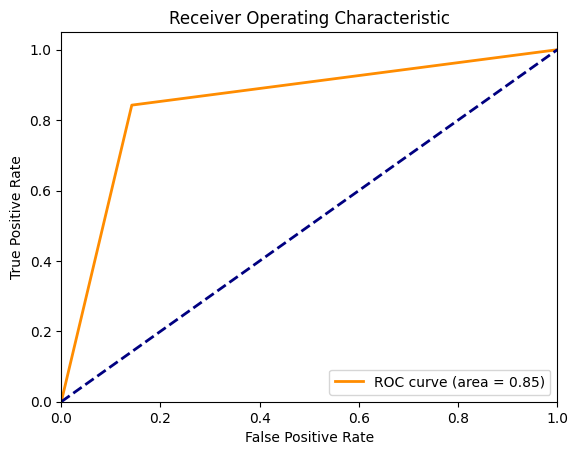

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


X = data_final.drop('status', axis=1)  # Características
y = data_final['status']  # Variable objetivo
X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.214285714, random_state=42)

# Guardar los conjuntos de datos de entrenamiento, validación y prueba en archivos CSV
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Creación del modelo
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.8530183727034121

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1697
           1       0.85      0.85      0.85      1732

    accuracy                           0.85      3429
   macro avg       0.85      0.85      0.85      3429
weighted avg       0.85      0.85      0.85      3429

Confusion Matrix on Test Set:
[[1446  251]
 [ 253 1479]]

Precision: 0.8549132947976879
Recall: 0.8539260969976905


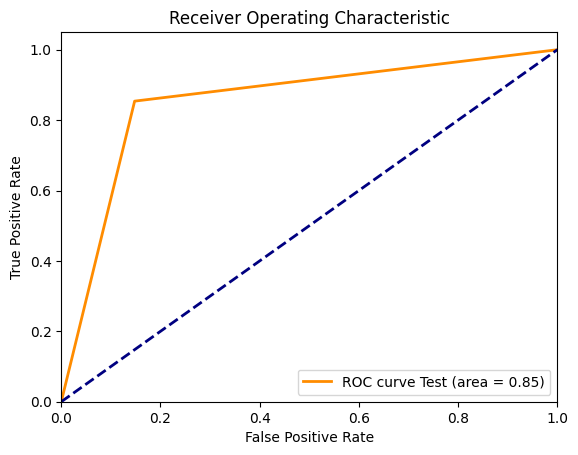

In [32]:
y_pred_test = rf_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)
roc_auc_t = auc(fpr_t, tpr_t)

plt.figure()
lw = 2
plt.plot(fpr_t, tpr_t, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### **Resultados**

Con un accuracy general de 85.0%, el modelo logra clasificar correctamente el 85.0% de las instancias en el conjunto de prueba. Los valores de precision, recall y f1-score para ambas clases (phishing y legítimo) son similares, rondando el 85%, lo que sugiere un buen equilibrio en la capacidad del modelo para predecir ambas clases de manera precisa. La matriz de confusión revela que los errores de clasificación se distribuyen de forma bastante equilibrada entre las dos clases, con una cantidad similar de falsos positivos y falsos negativos. En resumen, el modelo de clasificación basado en Random Forest muestra un rendimiento general positivo en la detección de sitios web de phishing, aunque podría mejorar en la precisión en algunos casos específicos. Además, se observa que las curvas ROC son prácticamente iguales, lo que es evidente debido a las mínimas variaciones en los decimales de los diferentes sets de prueba, aunque ambas pruebas arrojaron resultados positivos.

##### Modelo 2: SVM

Accuracy: 0.7743440233236152

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       851
           1       0.74      0.86      0.79       864

    accuracy                           0.77      1715
   macro avg       0.78      0.77      0.77      1715
weighted avg       0.78      0.77      0.77      1715

Confusion Matrix:
[[583 268]
 [119 745]]

Precision: 0.7354392892398816
Recall: 0.8622685185185185


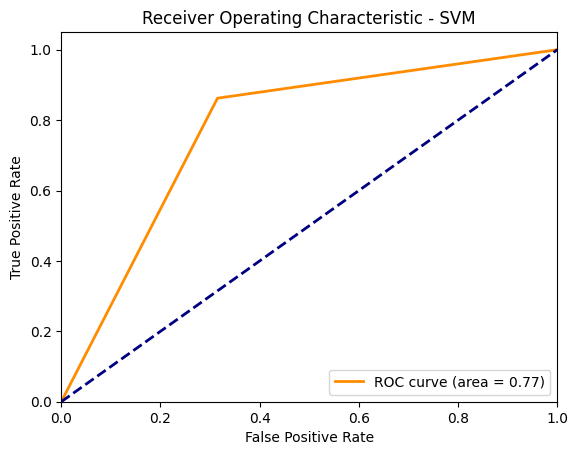

In [35]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)


print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

precision_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[0, 1])
recall_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[1, 0])
print("\nPrecision:", precision_svm)
print("Recall:", recall_svm)

#ROC y AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.7821522309711286

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1697
           1       0.75      0.86      0.80      1732

    accuracy                           0.78      3429
   macro avg       0.79      0.78      0.78      3429
weighted avg       0.79      0.78      0.78      3429

Confusion Matrix on Test Set:
[[1186  511]
 [ 236 1496]]

Precision: 0.7453911310413552
Recall: 0.8637413394919169


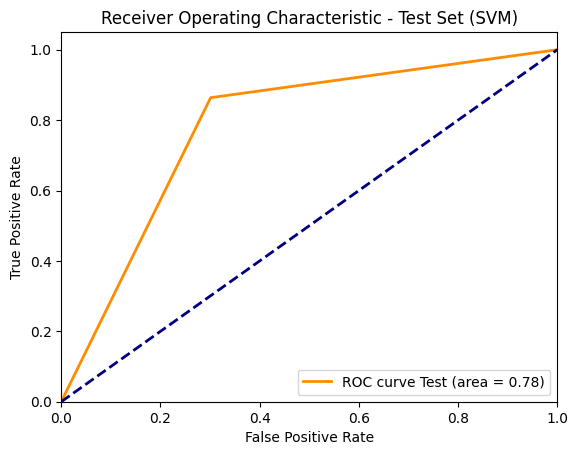

In [36]:
y_pred_test_svm = svm_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test_svm))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test_svm))

conf_matrix_test_svm = confusion_matrix(y_test, y_pred_test_svm)
print("Confusion Matrix on Test Set:")
print(conf_matrix_test_svm)

precision_test_svm = conf_matrix_test_svm[1, 1] / (conf_matrix_test_svm[1, 1] + conf_matrix_test_svm[0, 1])
recall_test_svm = conf_matrix_test_svm[1, 1] / (conf_matrix_test_svm[1, 1] + conf_matrix_test_svm[1, 0])
print("\nPrecision:", precision_test_svm)
print("Recall:", recall_test_svm)

# ROC y AUC
fpr_test_svm, tpr_test_svm, thresholds_test_svm = roc_curve(y_test, y_pred_test_svm)
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

plt.figure()
lw = 2
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_test_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (SVM)')
plt.legend(loc="lower right")
plt.show()

#### **Resultados**

El modelo SVM demostró un buen rendimiento al clasificar URLs como maliciosas o normales, alcanzando una precisión general de 78.22%. Se destaca por su capacidad para identificar la mayoría de las URLs maliciosas, con un recall del 86%, aunque presenta cierta dificultad al identificar URLs normales, con un recall del 70%. Aunque el modelo mantiene un equilibrio razonable entre precisión y recall, aún podría mejorarse con ajustes adicionales para optimizar la detección de URLs normales sin comprometer la precisión en la clasificación de URLs maliciosas.









### **Discusión**

- ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?
Un falso positivo puede tener muchos impactos negativos: 
    - Afecta la experiencia del usuario: Los usuarios legítimos pueden ser bloqueados o recibir advertencias innecesarias al intentar acceder a sitios confiables.
    - Pérdida de productividad: Si se clasifican incorrectamente sitios internos de la empresa como phishing, los empleados pueden perder acceso a recursos importantes.
    - Pérdida de credibilidad del sistema: Un modelo con muchos falsos positivos podría generar desconfianza en el equipo de seguridad, haciendo que los usuarios lo ignoren.
-  ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?
    - Aumento del riesgo de ataques exitosos: Los usuarios podrían ingresar credenciales o descargar malware creyendo que el sitio es seguro.
    - Pérdida de datos y brechas de seguridad: Los atacantes pueden robar información confidencial de la empresa o de los usuarios.
    - Impacto financiero: Un ataque exitoso puede generar pérdidas económicas significativas, desde fraudes hasta costos de recuperación de sistemas.
    - Pérdida de confianza: Si el modelo no detecta ataques de phishing, los empleados podrían dejar de confiar en la solución de seguridad.    

- En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?
Dado que los falsos negativos son más peligrosos que los falsos positivos: 
    - Recall (Sensibilidad o Tasa de Verdaderos Positivos):
        - Mide qué porcentaje de los correos o sitios de phishing fueron correctamente detectados.
        - Un recall alto significa que la mayoría de los ataques de phishing serán identificados.
        - Sin embargo, un recall alto a veces se logra a costa de más falsos positivos.
    - Precision (Precisión o Valor Predictivo Positivo):
        - Indica cuántos de los sitios que el modelo identificó como phishing realmente lo eran.
        - Un precision alto reduce las falsas alarmas, evitando que el equipo de seguridad pierda tiempo en revisiones innecesarias.
    - AUC-ROC (Área Bajo la Curva ROC): 
        - Evalúa la capacidad general del modelo para distinguir entre phishing y sitios legítimos.
        - Un AUC cercano a 1.0 indica un modelo excelente.


- ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?
El modelo Support Vector Machine: 
    - Precisión general del 78.22%
    - Recall del 86% para phishing (detectó la mayoría de los sitios maliciosos)
    - Recall del 70% para sitios legítimos (algunos sitios normales fueron marcados como phishing)

    El SVM funcionó bien en la detección de phishing, pero aún tiene un problema con falsos positivos. Con la finalidad deminimizar los falsos negativosy capturar la mayor cantidad de phishing posible, SVM es una buena opción. Sin embargo, podría mejorarse ajustando hiperparámetros.
- Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes
ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails,
un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y
cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué
propone para reducir la cantidad de falsas alarmas?


#### **Cálculo de la cantidad de emails phishing y legítimos**

-   Total de emails: **50,000**
-   Base rate de phishing: **15%**
    -   Phishing: **7,500 emails**
    -   Legítimos: **42,500 emails**

####  **Cálculo de True Positives (TP) y False Negatives (FN)**

-   Recall del modelo (86%):
    -   **TP (detectados correctamente)** = 86% de 7,500 → **6,450 phishing detectados**
    -   **FN (pasaron desapercibidos)** = 7,500 - 6,450 → **1,050 phishing no detectados**

####  **Cálculo de False Positives (FP) y True Negatives (TN)**

-   Recall para sitios legítimos (70%) → Indica que el modelo detecta correctamente el 70% de los correos legítimos.
    -   **TN (legítimos detectados correctamente)** = 70% de 42,500 → **29,750 emails legítimos bien clasificados**
    -   **FP (falsas alarmas, es decir, emails legítimos marcados como phishing)** = 30% de 42,500 → **12,750 falsas alarmas**

¿Funciona el modelo para este base rate del 15%?
No del todo, 
- Genera demasiadas falsas alarmas (12,750 emails legítimos marcados como phishing), lo que sobrecarga al equipo de seguridad.
- Aún deja pasar phishing (1,050 emails maliciosos no detectados), lo que representa un riesgo.

¿Cómo reducir la cantidad de falsas alarmas?
- Aumentar la especificidad 
    - Ajustar el umbral del modelo para reducir falsos positivos.
    - Usar técnicas como calibración de probabilidades para mejorar la confiabilidad del modelo.
- Aplicar un segundo filtro
    - Utilizar otro modelo con alta precisión antes de marcar un email como phishing.
    - Implementar reglas heurísticas adicionales (por ejemplo, verificar si la URL contiene dominios sospechosos o si el correo proviene de un remitente confiable).

- Uso de listas blancas
    - Mantener una base de datos de emails y dominios confiables para reducir las falsas alarmas.